# Vector Autoregression
## Motivation
From the Granger Causality Tests, we know that our attention proxies are actually relevant in predicting stock price (movements). With this in mind, we can try to fit a Vector Autoregression model to actually predict stock price.
## Prerequisites
- We know how to transform our non-stationary time series to stationary time series (see "detrend_and_granger_causality.ipynb".
- We can see som Granger causation - hence we should be able to fit a VAR model
## Sources
1. https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
2. https://en.wikipedia.org/wiki/Vector_autoregression

In [162]:
# Imports
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR
from statsmodels.stats.stattools import durbin_watson
import matplotlib.pyplot as plt
# from statsmodels.tools.eval_measures import rmse, aic
import warnings
warnings.filterwarnings("ignore")

In [163]:
# Granger Causality test (https://en.wikipedia.org/wiki/Granger_causality)
maxlag=15
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var for var in variables]  # [var + '_x' for var in variables]
    df.index = [var for var in variables]    # [var + '_y' for var in variables]
    return df

# ADF test (https://en.wikipedia.org/wiki/Augmented_Dickey–Fuller_test)
def adf_test(df):
    result = adfuller(df.values)

    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    # return p-value (relevant to dismiss null-hypothesis)
    # return result[1]

## Prepare the time series
| Ticker | Keyword |
|---|---|
| ALV.DE | Allianz |
| BRK-B | Berkshire Hathaway |
| BTC-USD | Bitcoin |
| DOGE-USD | Dogecoin |
| ETH-USD | Ethereum |
| JPM | JP Morgan |
| MSFT | Microsoft |
| NESN.SW | Nestle |
| NVDA | Nvidia |
| TSLA | Tesla |
| WIX | Wix.com |

In [164]:
ticker = 'BRK-B'
df = pd.read_csv(f'data/{ticker}.csv', comment='#', index_col=0)
df.index = pd.to_datetime(df.index)
df_transformed = df.diff().dropna()
columns = list(df_transformed.columns)

In [165]:
grangers_causation_matrix(df_transformed, variables = df.columns, verbose=False)

BRK-B (Open)  BRK-B (Close)  \
BRK-B (Open)                                  1.0000         0.0000   
BRK-B (Close)                                 0.0000         1.0000   
Google Trends Score Berkshire Hathaway        0.0358         0.0266   
GDELT Article Volume                          0.4428         0.0885   
GDELT Sentiment Score                         0.0783         0.1966   
BRK-B Trading Volume                          0.0154         0.0460   

                                        Google Trends Score Berkshire Hathaway  \
BRK-B (Open)                                                            0.0213   
BRK-B (Close)                                                           0.0220   
Google Trends Score Berkshire Hathaway                                  1.0000   
GDELT Article Volume                                                    0.0000   
GDELT Sentiment Score                                                   0.0013   
BRK-B Trading Volume                                                    0.0147   

                                        GDELT Article Volume  \
BRK-B (Open)                                          0.0388   
BRK-B (Close)                                         0.0433   
Google Trends Score Berkshire Hathaway                0.0868   
GDELT Article Volume                                  1.0000   
GDELT Sentiment Score                                 0.0001   
BRK-B Trading Volume                                  0.4010   

                                        GDELT Sentiment Score  \
BRK-B (Open)                                           0.0899   
BRK-B (Close)                                          0.0180   
Google Trends Score Berkshire Hathaway                 0.0325   
GDELT Article Volume                                   0.1477   
GDELT Sentiment Score                                  1.0000   
BRK-B Trading Volume                                   0.0437   

                                        BRK-B Trading Volume  
BRK-B (Open)                                          0.0000  
BRK-B (Close)                                         0.0069  
Google Trends Score Berkshire Hathaway                0.2954  
GDELT Article Volume                                  0.0546  
GDELT Sentiment Score                                 0.0097  
BRK-B Trading Volume                                  1.0000

### Cointegration Test

In [166]:
# Cointegration Test: https://www.jstor.org/stable/2938278?seq=1#page_scan_tab_contents
def cointegration_test(df, alpha=0.05):
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [167]:
cointegration_test(df_transformed)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
BRK-B (Open) ::  3324.75   > 83.9383   =>   True
BRK-B (Close) ::  2546.24   > 60.0627   =>   True
Google Trends Score Berkshire Hathaway ::  1886.93   > 40.1749   =>   True
GDELT Article Volume ::  1306.19   > 24.2761   =>   True
GDELT Sentiment Score ::  741.06    > 12.3212   =>   True
BRK-B Trading Volume ::  231.44    > 4.1296    =>   True


### Training and Testing Data

In [168]:
nobs = 365 # one year
df_train, df_test = df_transformed[0:-nobs], df_transformed[-nobs:]

## VAR Model

In [169]:
model = VAR(df_transformed)

In [170]:
# Select Order of VAR Model
x = model.select_order(maxlags=14)
x.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [171]:
maxlag = 13
model_fitted = model.fit(maxlag)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 29, Apr, 2024
Time:                     13:31:50
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    26.6052
Nobs:                     1743.00    HQIC:                   25.6688
Log likelihood:          -36256.9    FPE:                8.11723e+10
AIC:                      25.1195    Det(Omega_mle):     6.22160e+10
--------------------------------------------------------------------
Results for equation BRK-B (Open)
                                                coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------------------
const                                              0.033334         0.043254            0.771           0.441
L1.BRK-B (Open)                                

### Durbin Watson Statistic

In [172]:
out = durbin_watson(model_fitted.resid)
def adjust(val, length= 6): return str(val).ljust(length)
for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

BRK-B (Open) : 2.0
BRK-B (Close) : 2.0
Google Trends Score Berkshire Hathaway : 2.0
GDELT Article Volume : 2.0
GDELT Sentiment Score : 2.0
BRK-B Trading Volume : 2.0


### Forecast

In [173]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [174]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_transformed.values[-lag_order:]
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_1d')
df_forecast

13


BRK-B (Open)_1d  BRK-B (Close)_1d  \
2022-07-19        -0.495056         -0.627528   
2022-07-20        -0.338167          0.085647   
2022-07-21        -0.303847          0.326567   
2022-07-22        -0.171784          0.158861   
2022-07-25         0.429464          0.090263   
...                     ...               ...   
2023-12-22         0.112729          0.112769   
2023-12-26         0.112729          0.112769   
2023-12-27         0.112729          0.112769   
2023-12-28         0.112729          0.112769   
2023-12-29         0.112729          0.112769   

            Google Trends Score Berkshire Hathaway_1d  \
2022-07-19                                   0.075001   
2022-07-20                                  -0.151855   
2022-07-21                                   0.245028   
2022-07-22                                   0.812028   
2022-07-25                                  -0.088778   
...                                               ...   
2023-12-22                                  -0.000362   
2023-12-26                                  -0.000362   
2023-12-27                                  -0.000362   
2023-12-28                                  -0.000362   
2023-12-29                                  -0.000362   

            GDELT Article Volume_1d  GDELT Sentiment Score_1d  \
2022-07-19                -0.002530                 -0.116074   
2022-07-20                -0.002902                  0.098653   
2022-07-21                 0.000598                  0.033109   
2022-07-22                 0.007890                 -0.327846   
2022-07-25                 0.000073                  0.452755   
...                             ...                       ...   
2023-12-22                 0.000008                 -0.000437   
2023-12-26                 0.000008                 -0.000437   
2023-12-27                 0.000008                 -0.000437   
2023-12-28                 0.000008                 -0.000437   
2023-12-29                 0.000008                 -0.000437   

            BRK-B Trading Volume_1d  
2022-07-19            277571.909641  
2022-07-20            247008.122328  
2022-07-21           -311897.819160  
2022-07-22           -250782.252517  
2022-07-25            125418.066470  
...                             ...  
2023-12-22               -83.425798  
2023-12-26               -83.425798  
2023-12-27               -83.425798  
2023-12-28               -83.425798  
2023-12-29               -83.425798  

[365 rows x 6 columns]

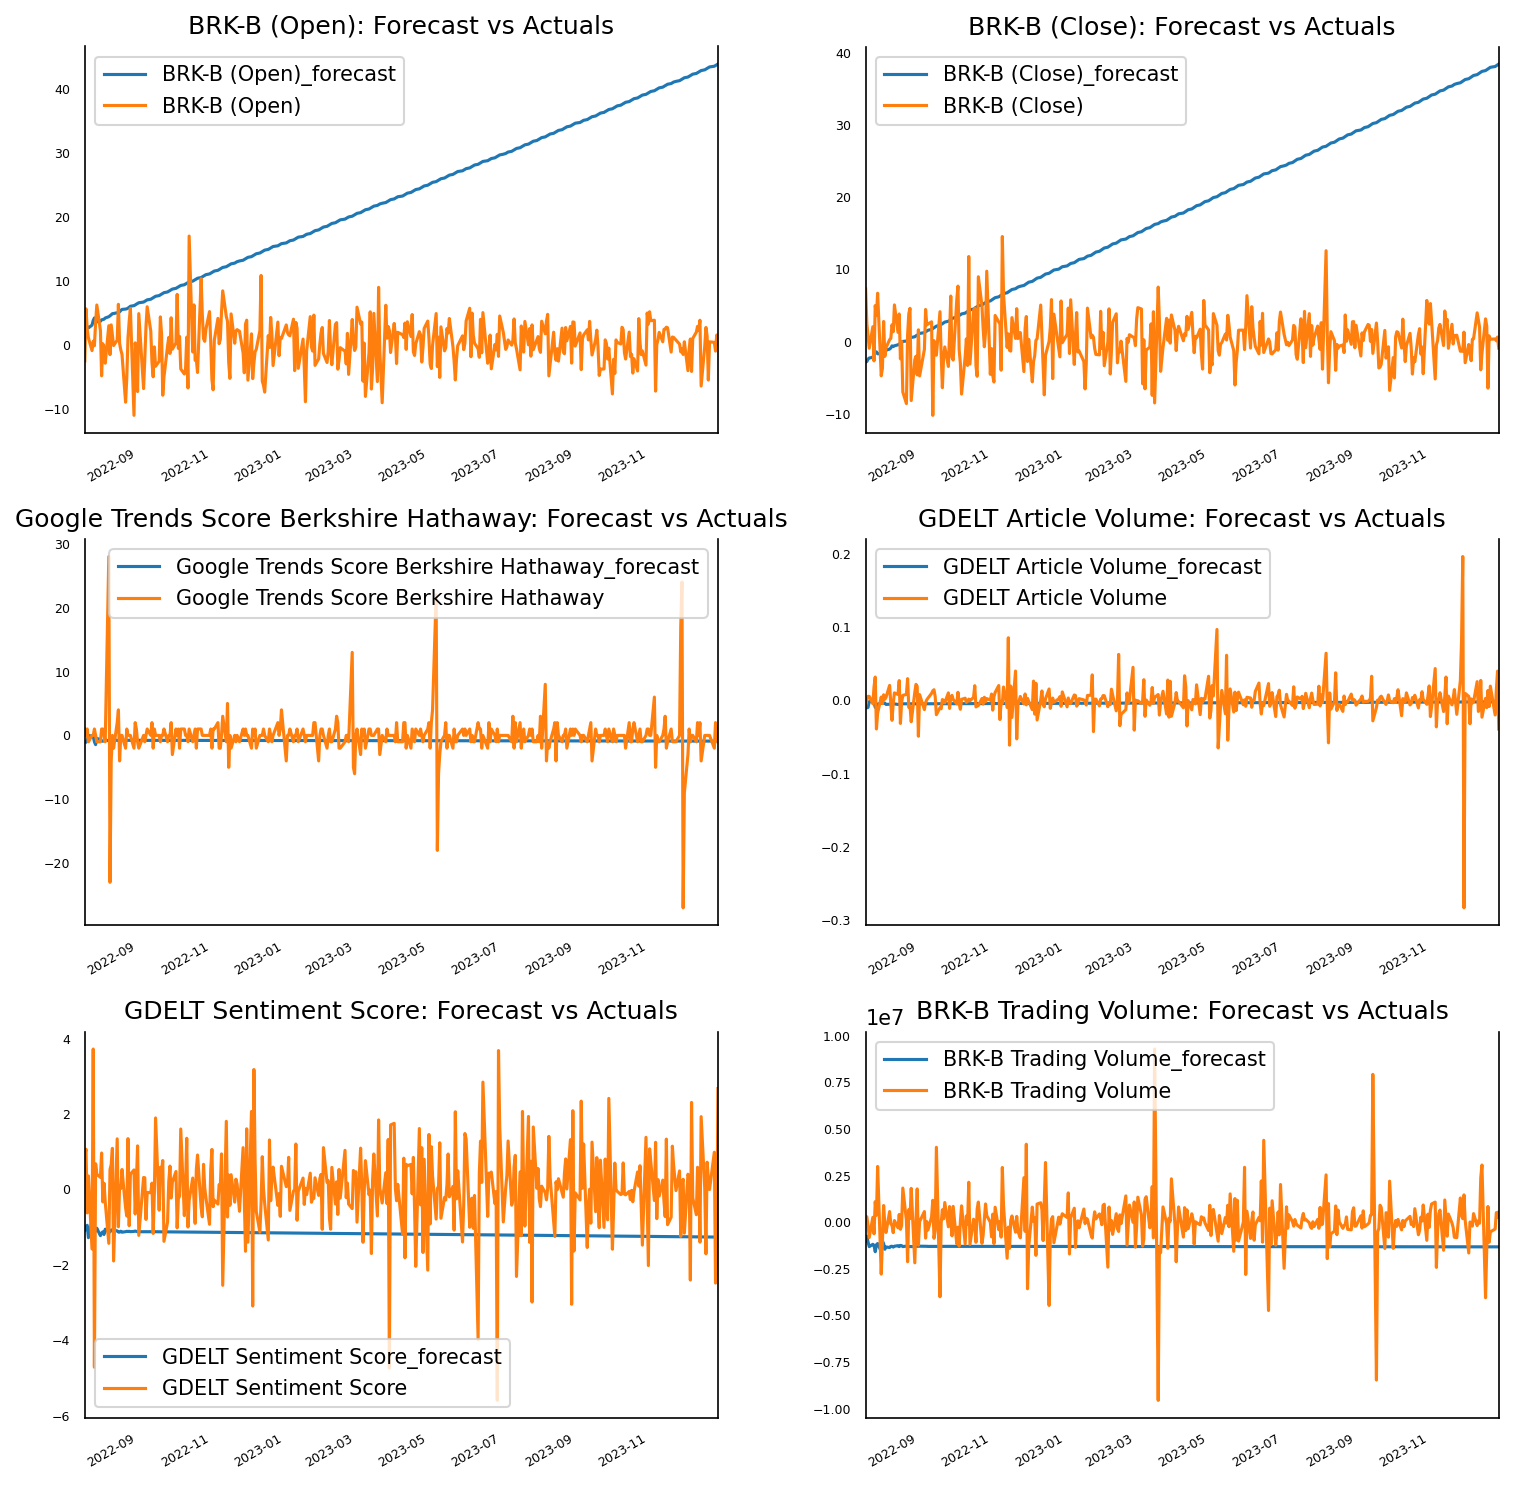

In [175]:
df_results = invert_transformation(df_train, df_forecast, second_diff=False)

fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();